In [37]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import datetime
%load_ext tensorboard
from tensorboard.plugins import projector
import matplotlib.pyplot as plt

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [38]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [39]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(latent_dim * 8, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 14, 14, 32)   320         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_6[0][0]                   
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 7, 7, 64)     256         conv2d_7[0][0]                   
____________________________________________________________________________________________

In [40]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_7 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 14, 14, 64)        36928     
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 28, 28, 32)        18464     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 28, 28, 1)         289       
Total params: 65,089
Trainable params: 65,089
Non-trainable params: 0
_______________________________________________________

In [41]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")


    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, x):
        mu, log_sigma, z = self.encoder(x)
        x_decoded = self.decoder(z)
        return mu, log_sigma, x_decoded, z

In [42]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train =  np.expand_dims(x_train, -1).astype('float32') / 255.
x_test =  np.expand_dims(x_test, -1).astype('float32') / 255.
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

tensorboard_log_dir = os.path.join("logs/fit/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
os.makedirs(tensorboard_log_dir, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_log_dir, histogram_freq=1)

vae.fit(x_train, epochs=30, batch_size=128, callbacks=[tensorboard_callback])

Epoch 1/30
469/469 [==============================] - 3s 5ms/step - loss: 258.2076 - reconstruction_loss: 203.9291 - kl_loss: 2.7445
Epoch 2/30
469/469 [==============================] - 2s 5ms/step - loss: 171.3587 - reconstruction_loss: 163.7369 - kl_loss: 4.6780
Epoch 3/30
469/469 [==============================] - 2s 5ms/step - loss: 161.8791 - reconstruction_loss: 156.1896 - kl_loss: 5.2214
Epoch 4/30
469/469 [==============================] - 2s 5ms/step - loss: 158.8022 - reconstruction_loss: 152.9744 - kl_loss: 5.4616
Epoch 5/30
469/469 [==============================] - 2s 5ms/step - loss: 157.4931 - reconstruction_loss: 151.0103 - kl_loss: 5.5779
Epoch 6/30
469/469 [==============================] - 2s 5ms/step - loss: 155.3203 - reconstruction_loss: 149.3797 - kl_loss: 5.6983
Epoch 7/30
469/469 [==============================] - 2s 4ms/step - loss: 153.9721 - reconstruction_loss: 148.1094 - kl_loss: 5.7812
Epoch 8/30
469/469 [==============================] - 2s 4ms/step - l

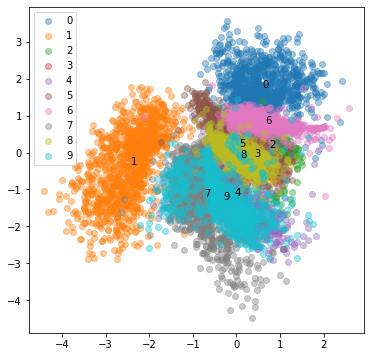

In [43]:
mu, sigma, z = vae.encoder.predict(x_test) # 0番目：平均, 1番目: log標準偏差, 2番目: 潜在変数+

plt.figure(figsize=(6, 6))
for i in range(10):
    index = y_test == i
    plt.scatter(z[index, 0], z[index, 1], label=str(i), alpha=0.4)
    z1_mean = z[index, 0].mean()
    z2_mean = z[index, 1].mean()
    plt.annotate(str(i), (z1_mean, z2_mean))

plt.legend()
plt.show()

ラベル:  2


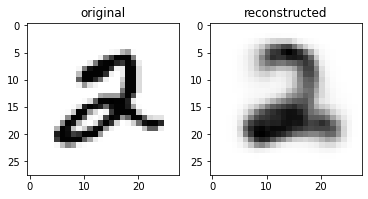

In [44]:
i = 5
mu, log_sigma, reconstructed, z = vae(x_train[i][None,...])
print('ラベル: ', y_train[i])
fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].imshow(x_train[i].reshape(28, 28) * 255, cmap='Greys');
ax[0].set_title('original')
ax[1].imshow(reconstructed.numpy().reshape(28, 28) * 255, cmap='Greys');
ax[1].set_title('reconstructed')
plt.show()

In [45]:
z1 = np.linspace(-0.5,0,100)
z2 = np.linspace(0.5, -3, 100)

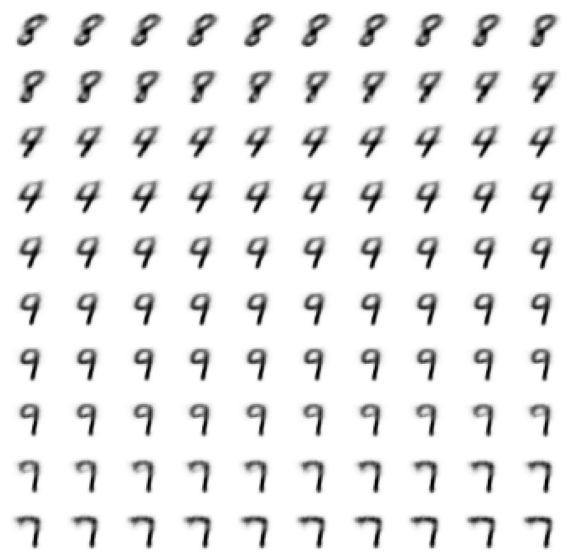

In [46]:
num_of_rows = 10
fig, ax = plt.subplots(nrows=num_of_rows, ncols=num_of_rows, figsize=(10, 10))
for i, (z1_, z2_) in enumerate(zip(z1, z2)):
    sampled = vae.decoder(np.array([z1_, z2_]).reshape(1, 2))
    ax[divmod(i, num_of_rows)].imshow(sampled.numpy().reshape(28, 28) * 255, cmap='Greys');
    ax[divmod(i, num_of_rows)].set_axis_off()
plt.show()

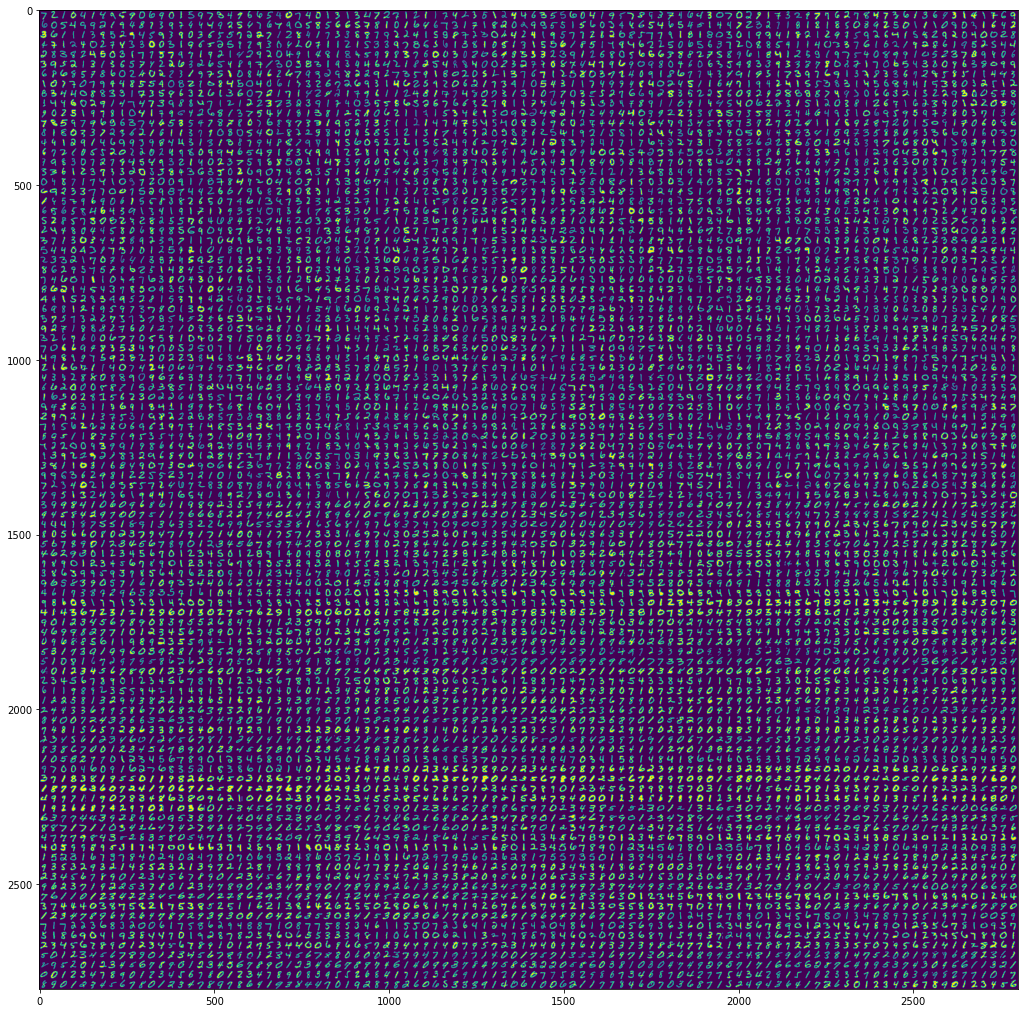

In [11]:
def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    # MNISTは28ピクセル四方 
    img_h = images.shape[1]
    img_w = images.shape[2]

    # 画像数の平方根(切上)を計算(Sprite Imageの1辺の長さに使用)
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))

    # 全要素0の配列作成
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))

    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j

            # 画像がある限り実行(n_plotsが割り切れないためSprite Imageは少し余る)
            if this_filter < images.shape[0]:

                # Sprite Imageの所定の配列に画像を挿入
                spriteimage[i * img_h:(i + 1) * img_h, j * img_w:(j + 1) * img_w] = images[this_filter]

    return spriteimage

# Sprite Image生成
sprite_image = create_sprite_image(x_test[...,0])

# Sprite Image表示
plt.figure(figsize=(18,18))
plt.imshow(sprite_image)

# Sprite Image保存
plt.imsave('sprites.png', sprite_image, cmap='gray')

In [19]:
# メタデータ作成・保存
with open('metadata.tsv', 'w') as f:
    f.write("Index\tLabel\n")
    for index,label in enumerate(y_test):
        f.write("%d\t%d\n" % (index,label))

# メタデータのチェック
!head metadata.tsv

Index	Label
0	7
1	2
2	1
3	0
4	4
5	1
6	4
7	9
8	5


In [16]:
_, _, z = vae.encoder.predict(x_test)
embedding_var = tf.Variable(z, name="z")

checkpoint = tf.train.Checkpoint(embedding=embedding_var)
checkpoint.save(os.path.join(tensorboard_log_dir, "embedding.ckpt"))

# Projector設定
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# メタデータ(CSV)パス
embedding.metadata_path='metadata.tsv'

# TODO use this
# Sprite Imageパスと設定
embedding.sprite.image_path='sprites.png'
embedding.sprite.single_image_dim.extend([28,28])

# Projectorに出力
projector.visualize_embeddings(tensorboard_log_dir, config)
